#### This notebook analyses some sea ice diagnostics.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from datetime import timedelta

from dask.distributed import Client

%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Client Scheduler: tcp://127.0.0.1:40399 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 128.85 GB


In [3]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,150429
1,output111,2096
2,output112,2096
3,output113,2096
4,output114,2096
5,output115,2096
6,output116,2096
7,output117,2096
8,output118,2096
9,output119,2096


In [5]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

cc.querying.get_variables(session, experiment='1deg_jra55_ryf_cont')

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
0,GRID_X_T,None,None,restart053/ice/monthly_sstsss.nc,71,None,None
1,GRID_Y_T,None,None,restart053/ice/monthly_sstsss.nc,71,None,None
2,GRID_Y_T_bnds,None,None,restart053/ice/monthly_sstsss.nc,71,None,None
3,SALT,SALT,None,restart053/ice/monthly_sstsss.nc,71,None,None
4,TEMP,TEMP,None,restart053/ice/monthly_sstsss.nc,71,None,None
5,TMONTH,None,None,restart053/ice/monthly_sstsss.nc,71,None,None
6,Time,Time,None,restart076/ocean/ocean_sigma_transport.res.nc,966,None,None
7,Tsfcn,None,None,restart083/ice/iced.2319-01-01-00000.nc,355,None,None
8,advectionu,advectionu,None,restart104/ocean/ocean_velocity_advection.res.nc,69,None,None
9,advectionv,advectionv,None,restart104/ocean/ocean_velocity_advection.res.nc,69,None,None


In [8]:
yr_beg = '2400-01-01'

expt = '1deg_jra55_ryf_cont'

ice = cc.querying.getvar(expt, 'aice_m', session, decode_coords=False, start_time = yr_beg)
ice['time'] = ice.time - timedelta(hours=12)
area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
ice.coords['ni'] = area_t['xt_ocean'].values
ice.coords['nj'] = area_t['yt_ocean'].values
ice = ice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
area = ice * area_t
area_zonalsum = area.sum('xt_ocean')
SH_area_cont = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
NH_area_cont = area_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean').load()

In [9]:
expt = '1deg_jra55_ryf_rcp45cool_spinup500'

ice = cc.querying.getvar(expt, 'aice_m', session, decode_coords=False)
ice['time'] = ice.time - timedelta(hours=12)
area_t = cc.querying.getvar(expt, 'area_t',session, n=1)
ice.coords['ni'] = area_t['xt_ocean'].values
ice.coords['nj'] = area_t['yt_ocean'].values
ice = ice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
areaw = ice * area_t
area_zonalsum = areaw.sum('xt_ocean')
SH_area_cool = area_zonalsum.sel(yt_ocean = slice(-90, -45)).sum('yt_ocean').load()
NH_area_cool = area_zonalsum.sel(yt_ocean = slice(0, 90)).sum('yt_ocean').load()

In [10]:
expt = '1deg_jra55_ryf_rcp45warm_spinup500'

ice = cc.querying.getvar(expt, 'aice_m', session, decode_coords=False)
ice['time'] = ice.time - timedelta(hours=12)
area_t = cc.querying.getvar(expt, 'area_t',session, n=1)
ice.coords['ni'] = area_t['xt_ocean'].values
ice.coords['nj'] = area_t['yt_ocean'].values
ice = ice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
areaw = ice * area_t
area_zonalsum = areaw.sum('xt_ocean')
SH_area_warm = area_zonalsum.sel(yt_ocean = slice(-90, -45)).sum('yt_ocean').load()
NH_area_warm = area_zonalsum.sel(yt_ocean = slice(0, 90)).sum('yt_ocean').load()

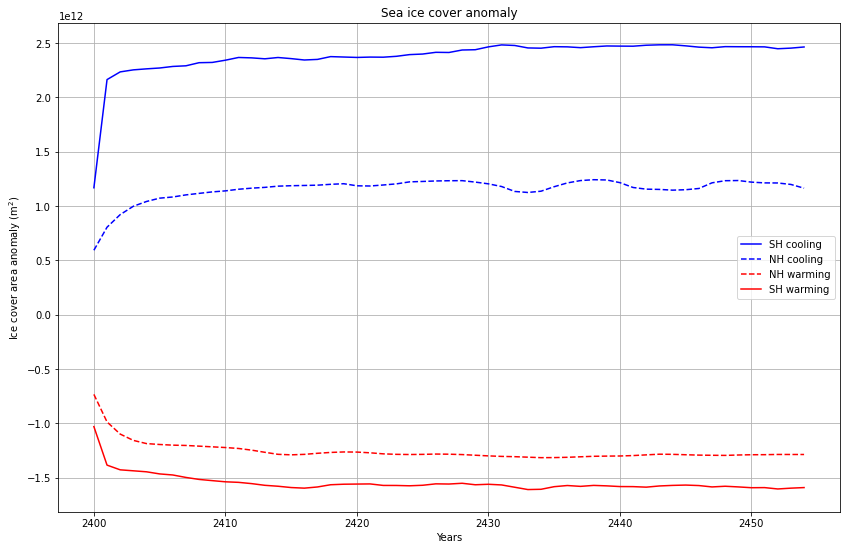

In [23]:
plt.figure(figsize=(14, 9))
(SH_area_cool - SH_area_cont).groupby('time.year').mean('time').plot(label = 'SH cooling', color = 'b')
(NH_area_cool - NH_area_cont).groupby('time.year').mean('time').plot(label = 'NH cooling', color = 'b', linestyle = '--')
(NH_area_warm - NH_area_cont).groupby('time.year').mean('time').plot(label = 'NH warming', color = 'r', linestyle = '--')
(SH_area_warm - SH_area_cont).groupby('time.year').mean('time').plot(label = 'SH warming', color = 'r')

plt.title('Sea ice cover anomaly')
plt.ylabel('Ice cover area anomaly (m$^2$)')
plt.xlabel('Years')
plt.grid()
plt.legend()
#plt.savefig('ice_cover.jpg')